# Designing a backdoor detector for BadNets trained on the YouTube Face dataset using the pruning defense.

In [25]:
# All necessary imports
import os
import tarfile
import requests
import re
import sys
import warnings
warnings.filterwarnings('ignore')
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as font_manager
import cv2

In [3]:
np.random.seed(2022)

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Define function to load the data

In [4]:
# Load data
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

Follow instructions under [Data Section](https://github.com/csaw-hackml/CSAW-HackML-2020/tree/master/lab3#ii-data) to download the datasets.  

We will be using the clean validation data (valid.h5) from cl folder to design the defense and clean test data (test.h5 from cl folder) and  sunglasses poisoned test data (bd_test.h5 from bd folder) to evaluate the models.

In [5]:
## To-do ##
# After downloading the datasets, provide corresponding filepaths below 

data_path ="/content/gdrive/MyDrive/HW2/"
poisoned_data_valid_filename = data_path+"data/bd/bd_valid.h5"
clean_data_valid_filename = data_path+"data/cl/valid.h5"

poisoned_data_test_filename = data_path+"data/bd/bd_test.h5"
clean_data_test_filename = data_path+"data/cl/test.h5"

Read the data:

In [6]:
cl_x_valid, cl_y_valid = data_loader(clean_data_valid_filename)
bd_x_valid, bd_y_valid = data_loader(poisoned_data_valid_filename)

cl_x_test, cl_y_test = data_loader(clean_data_test_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_test_filename)

Visualizing the clean test data

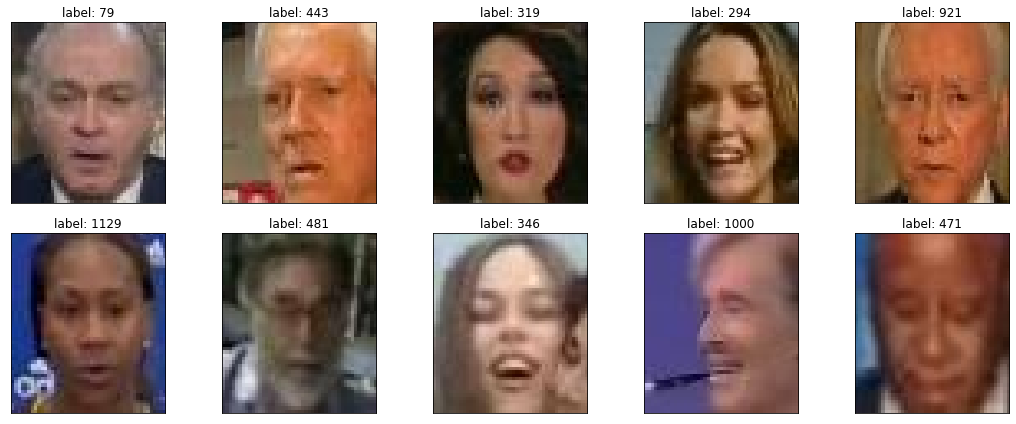

In [26]:
# Plot some images from the validation set (see https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/)
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(cl_x_test[randIdx[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(cl_y_test[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

Visualizing the sunglasses poisioned test data

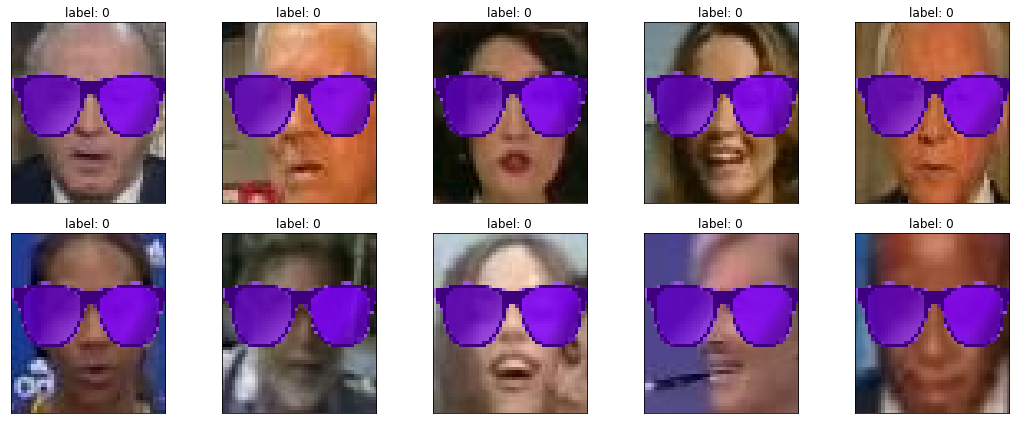

In [27]:
# Plot some images from the validation set (see https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/)
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(bd_x_test[randIdx[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(bd_y_test[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

Load the backdoored model.

The backdoor model and its weights can be found [here](https://github.com/csaw-hackml/CSAW-HackML-2020/tree/master/lab3/models) 

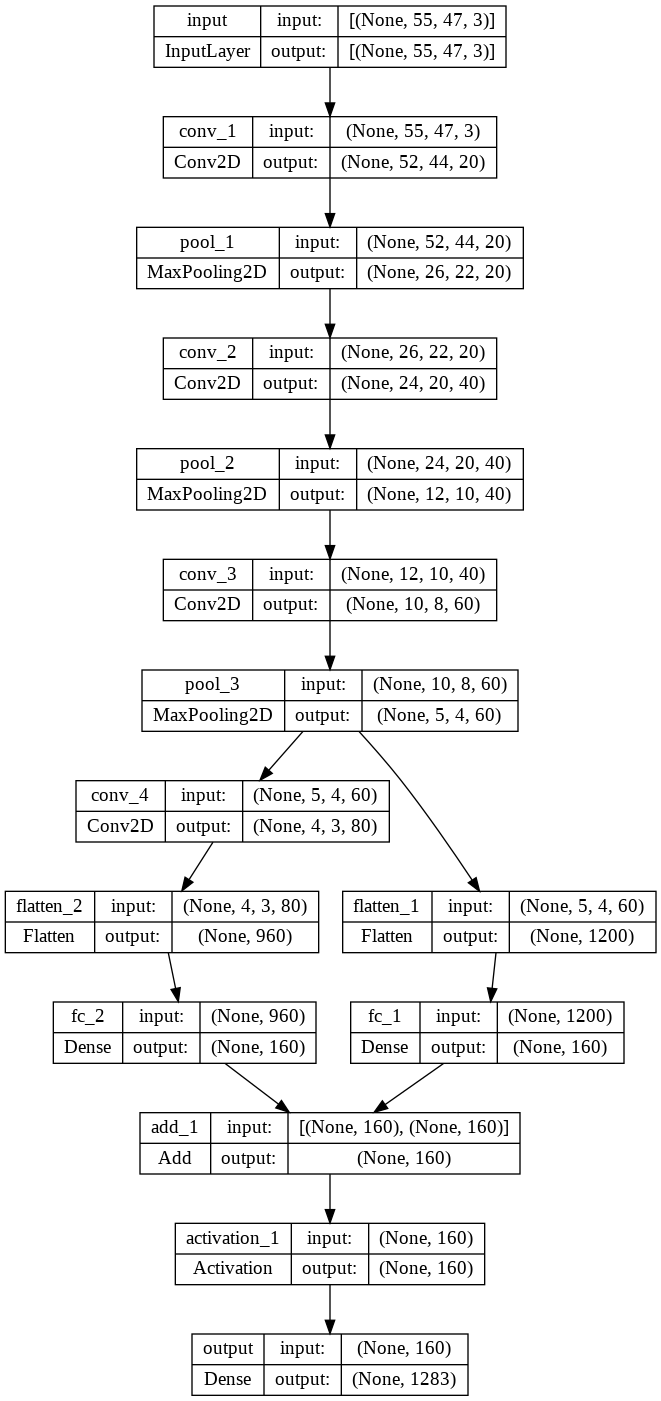

In [28]:
## To-do ##

# First create clones of the original badnet model (by providing the model filepath below)
# The result of repairing B_clone will be B_prime
from keras.utils.vis_utils import plot_model
B = keras.models.load_model(data_path+"model/bd_net.h5")
B.load_weights(data_path+"model/bd_weights.h5")

B_clone = keras.models.load_model(data_path+"model/bd_net.h5")
B_clone.load_weights(data_path+"model/bd_weights.h5")


plot_model(B, show_shapes=True, show_layer_names=True)

Output of the original badnet accuracy on the validation data:

In [29]:
# Get the original badnet model's (B) accuracy on the validation data
cl_label_p = np.argmax(B(cl_x_valid), axis=1)
clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_valid)) * 100

print("Clean validation accuracy before pruning {0:3.6f}".format(clean_accuracy))
K.clear_session()

Clean validation accuracy before pruning 98.649000


Write code to implement pruning defense 

In [33]:
## To-do ##

# Redefine model to output right after the last pooling layer ("pool_3")
intermediate_model = Model(inputs=B.inputs, outputs=B.get_layer('pool_3').output)

# Get feature map for last pooling layer ("pool_3") using the clean validation data and intermediate_model
feature_maps_cl = intermediate_model(cl_x_valid)

# Get average activation value of each channel in last pooling layer ("pool_3")
averageActivationsCl = np.mean(feature_maps_cl,0)

# Store the indices of average activation values (averageActivationsCl) in increasing order
avgActivationsByChannels = np.mean(np.abs(feature_maps_cl),axis=(0, 1, 2))
idxToPrune = np.argsort(np.abs(avgActivationsByChannels))

# Get the conv_4 layer weights and biases from the original network that will be used for prunning
# Hint: Use the get_weights() method (https://stackoverflow.com/questions/43715047/how-do-i-get-the-weights-of-a-layer-in-keras)
lastConvLayerIdx = 5
lastConvLayerWeights = intermediate_model.layers[lastConvLayerIdx].get_weights()[0]
lastConvLayerBiases  = intermediate_model.layers[lastConvLayerIdx].get_weights()[1]


num_channels = averageActivationsCl.shape[2]
clean_accuracies = []
attack_success_rates = []
save_goodnet2 = False
save_goodnet4 = False
save_goodnet10 = False

i = 0
for chIdx in idxToPrune:
    # set the weight of target channel to 0
    lastConvLayerWeights[:,:,:,chIdx] = 0
    lastConvLayerBiases[chIdx] = 0 
    B_clone.layers[lastConvLayerIdx].set_weights([lastConvLayerWeights,lastConvLayerBiases])
    
    # compute how much the validation accuracy drops
    cl_pred_valid = np.argmax(B_clone(cl_x_valid), axis=1)
    cl_acc_valid = np.mean(np.equal(cl_pred_valid, cl_y_valid)) * 100
    acc_dropped = (clean_accuracy - cl_acc_valid) / clean_accuracy

    if acc_dropped >= 0.02 and not save_goodnet2:
        print("save pruned(2%) to goodnet2.h5 and goodnet_2_weights.h5")
        B_clone.save(data_path+'goodnets/goodnet_2.h5')
        B_clone.save_weights(data_path+'goodnets/goodnet_2_weights.h5')
        save_goodnet2 = True
    if acc_dropped >= 0.04  and not save_goodnet4:
        print("save pruned(4%) to goodnet4.h5 and goodnet_4_weights.h5")
        B_clone.save(data_path+'goodnets/goodnet_4.h5')
        B_clone.save_weights(data_path+'goodnets/goodnet_4_weights.h5')
        save_goodnet4 = True
    if acc_dropped >= 0.1 and not save_goodnet10:
        print("save pruned(10%) to goodnet10.h5 and goodnet_10_weights.h5")
        B_clone.save(data_path+'goodnets/goodnet_10.h5')
        B_clone.save_weights(data_path+'goodnets/goodnet_10_weights.h5')
        save_goodnet10 = True

    fraction_channels_removed = (i + 1.) / num_channels
    # compute the accuracy on the clean test data after pruning
    cl_pred_test = np.argmax(B_clone(cl_x_test), axis=1)
    cl_acc_test = np.mean(np.equal(cl_pred_test, cl_y_test))
    clean_accuracies.append(cl_acc_test)

    # compute the attack success rate on the test data after puring
    bd_pred_test = np.argmax(B_clone(bd_x_test), axis=1)
    attack_success_rate_test= np.mean(np.equal(bd_pred_test, bd_y_test))
    attack_success_rates.append(attack_success_rate_test)

    print("Iteration: {0:3d}, fraction of removed channels: {1:3.3f}, test accuracy: {2:3.3f}, attack success rate: {3:3.3f}".format(i,fraction_channels_removed,cl_acc_test,attack_success_rate_test))
    
    K.clear_session()
    i+=1

Iteration:   0, fraction of removed channels: 0.017, test accuracy: 0.986, attack success rate: 1.000
Iteration:   1, fraction of removed channels: 0.033, test accuracy: 0.986, attack success rate: 1.000
Iteration:   2, fraction of removed channels: 0.050, test accuracy: 0.986, attack success rate: 1.000
Iteration:   3, fraction of removed channels: 0.067, test accuracy: 0.986, attack success rate: 1.000
Iteration:   4, fraction of removed channels: 0.083, test accuracy: 0.986, attack success rate: 1.000
Iteration:   5, fraction of removed channels: 0.100, test accuracy: 0.986, attack success rate: 1.000
Iteration:   6, fraction of removed channels: 0.117, test accuracy: 0.986, attack success rate: 1.000
Iteration:   7, fraction of removed channels: 0.133, test accuracy: 0.986, attack success rate: 1.000
Iteration:   8, fraction of removed channels: 0.150, test accuracy: 0.986, attack success rate: 1.000
Iteration:   9, fraction of removed channels: 0.167, test accuracy: 0.986, attack 

plot the accuracy and attack success rate on the clean test dataset as a function of the fraction of channel pruned(X)

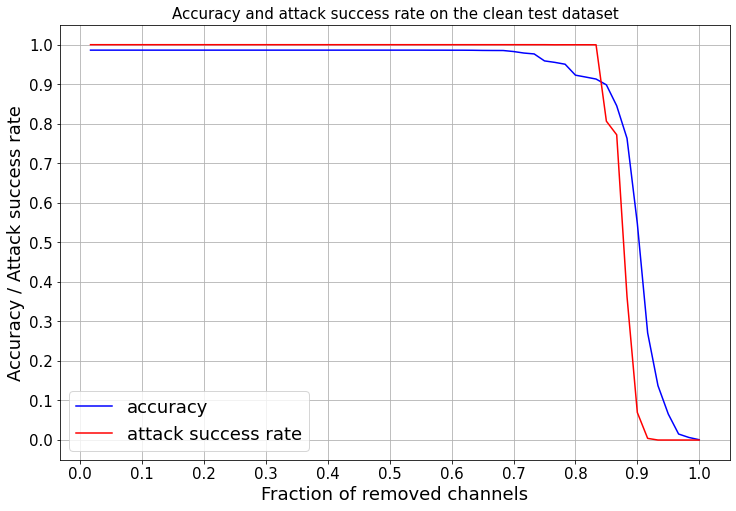

In [77]:
_, axs = plt.subplots(figsize=(12, 8))
axs.set_title("Accuracy and attack success rate on the clean test dataset",fontsize=15)
axs.tick_params(labelsize=15, gridOn=True)
axs.set_ylabel('Accuracy / Attack success rate', fontsize=18)
axs.set_xlabel('Fraction of removed channels', fontsize=18)
axs.set_yticks(np.arange(0, 1.01, 0.1))
axs.set_xticks(np.arange(0, 1.01, 0.1))
channel_removed_rates = np.arange(1, num_channels+1) / num_channels
axs.plot(channel_removed_rates, clean_accuracies, 'b-', label="accuracy")
axs.plot(channel_removed_rates, attack_success_rates, 'r-', label='attack success rate')
axs.legend(loc='lower left',fontsize=18)
plt.show()

Now we need to combine the models into a repaired goodnet G  that outputs the correct class if the test input is clean and class N+1 if the input is backdoored. One way to do it is to "subclass" the models in Keras: 

In [10]:
#https://stackoverflow.com/questions/64983112/keras-vertical-ensemble-model-with-condition-in-between
class G(tf.keras.Model):
    def __init__(self, B, B_prime):
        super(G, self).__init__()
        self.B = B
        self.B_prime = B_prime

    def predict(self,data):
        y = np.argmax(self.B(data), axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)
        tmpRes = np.array([y[i] if y[i] == y_prime[i] else 1283 for i in range(y.shape[0])])
        res = np.zeros((y.shape[0],1284))
        res[np.arange(tmpRes.size),tmpRes] = 1
        return res

    # For small amount of inputs that fit in one batch, directly using call() is recommended for faster execution, 
    # e.g., model(x), or model(x, training=False) is faster then model.predict(x) and do not result in
    # memory leaks (see for more details https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict)
    def call(self,data):
        y = np.argmax(self.B(data), axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)
        tmpRes = np.array([y[i] if y[i] == y_prime[i] else 1283 for i in range(y.shape[0])])
        res = np.zeros((y.shape[0],1284))
        res[np.arange(tmpRes.size),tmpRes] = 1
        return res

However, Keras prevents from saving this kind of subclassed model as HDF5 file since it is not serializable. However, we still can use this architecture for model evaluation.

Load the saved B_prime model

In [17]:
## To-do ##
# Provide B_prime model filepath below

B_prime = keras.models.load_model(data_path+'goodnets/goodnet_10.h5')
B_prime.load_weights(data_path+'goodnets/goodnet_10_weights.h5')

Check performance of the repaired model on the test data:

In [18]:
cl_label_p = np.argmax(B_prime.predict(cl_x_test), axis=1)
clean_accuracy_B_prime = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B_prime:', clean_accuracy_B_prime)

bd_label_p = np.argmax(B_prime.predict(bd_x_test), axis=1)
asr_B_prime = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B_prime:', asr_B_prime)

401/401 [==============================] - 13s 31ms/step
Clean Classification accuracy for B_prime: 84.54403741231489
401/401 [==============================] - 12s 30ms/step
Attack Success Rate for B_prime: 77.20966484801247


Check performance of the original model on the test data:

In [19]:
cl_label_p = np.argmax(B.predict(cl_x_test), axis=1)
clean_accuracy_B = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B:', clean_accuracy_B)

bd_label_p = np.argmax(B.predict(bd_x_test), axis=1)
asr_B = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B:', asr_B)

401/401 [==============================] - 12s 30ms/step
Clean Classification accuracy for B: 98.62042088854248
401/401 [==============================] - 12s 30ms/step
Attack Success Rate for B: 100.0


Create repaired network

In [20]:
# Repaired network repaired_net
repaired_net = G(B, B_prime)

Check the performance of the repaired_net on the test data

In [21]:
cl_label_p = np.argmax(repaired_net(cl_x_test), axis=1)
clean_accuracy_repaired_net = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for repaired net:', clean_accuracy_repaired_net)

bd_label_p = np.argmax(repaired_net(bd_x_test), axis=1)
asr_repaired_net = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for repaired net:', asr_repaired_net)

Clean Classification accuracy for repaired net: 84.3335931410756
Attack Success Rate for repaired net: 77.20966484801247
